# Welcome to the Tutorial measuring intrinsic absorption parameter!

This Notebook calculate the scattering & intrinsic absorption parameters of the Rayleigh waves following the instruction proposed by Hirose et al. (2019).

## **Publication about this script**:
Hirose, T., Nakahara, H., & Nishimura, T. (2019). A passive estimation method of scattering and intrinsic absorption parameters from envelopes of seismic ambient noise cross‐correlation functions. Geophysical Research Letters, 46(7), 3634-3642. https://doi.org/10.1029/2018GL080553

Hirose, T., Ueda, H., & Fujita, E. (2022). Scattering and intrinsic absorption parameters of Rayleigh waves at 18 active volcanoes in Japan inferred using seismic interferometry. Bulletin of Volcanology, 84(3), 34. https://doi.org/10.1007/s00445-022-01536-w

### This notebook demonstrates single-station measurements

Step: <br>
0) Data preparing and filtering <br> 1) Calculation of mean-squared (MS) envelopes --> observed energy densities (Eobs) <br> 
2) Calculation of synthesized energy densities (Esyn) via a grid search <br>
3) Determination of best-fit parameters: intrinsic absorption parameter *b* (for single station)<br>

In [ ]:
import os
import sys
import glob
import obspy
import numpy as np

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pyasdf
import scipy
import math

from obspy.signal.filter import bandpass
from noisepy.seis.application_modules.esyn_utils import *

### Step 0 ---  Data preparing and filtering 

In [ ]:
path="/home/kffeng/NoisePy/tutorials/get_started_data/STACK/CI.ADO/"
sfiles = sorted(glob.glob(os.path.join(path, 'CI.ADO_CI.ADO.h5')))
print(sfiles)
sta_pair=sfiles[0].split(path)[1].split(".h5")[0]
print(sta_pair)

In [ ]:
comp_arr = ["EN","EZ","NZ"] 
num_cmp=len(comp_arr)
fnum=len(sfiles)
print(fnum, num_cmp )

In [ ]:
lag=200 
samp=20
leng=int(lag*samp*2+1)
npts=leng
print(lag,samp,leng)

In [ ]:
def plot_waveforms(ncmp,wav,fname,comp_arr):
    fig, ax = plt.subplots(1,ncmp, figsize=(16,3), sharex=False)
    
    for n in range(ncmp):
        absy=max(wav[n][1], key=abs)
        ax[n].set_ylim(absy*-1,absy)
        ax[n].plot(wav[n][0],wav[n][1])
        ax[n].set_xlabel("time [s]")
        ax[n].set_title(fname+" "+comp_arr[n])
    fig.tight_layout()
    plt.show()

In [ ]:
stackf=np.ndarray((fnum,num_cmp,2,leng))  
print(stackf.shape)
vdist=np.zeros((fnum,1))  # S-R distance array
fname=[]                  # file name array


aa=0
# loop through each station-pair
for sfile in sfiles:
    ncmp=0
    sta_pair=path.split(path)[1].split(".h5")[0]
    fname.append(sta_pair)
    for ccomp in comp_arr:        
        print(aa, sfile, ccomp)
        # read stacked waveforms
        if ( read_pyasdf(sfile,ccomp) == None):
            continue
        dist,dt, tvec,sdata = read_pyasdf(sfile,ccomp) # read waveform from pyasdf 
        stackf[aa][ncmp]=[tvec,sdata]
        vdist[aa]=dist
        ncmp=ncmp+1
    plot_waveforms(num_cmp,stackf[aa],fname[aa],comp_arr)
    
    aa=aa+1
fnum=len(fname)


In [ ]:
def plot_filtered_waveforms(freq,tt,wav,fname):
    nfreq = len(freq) - 1
    fig, ax = plt.subplots(1,nfreq, figsize=(16,3), sharex=False)
    
    for fb in range(nfreq):
        fmin=freq[fb]
        fmax=freq[fb+1]
        absy=max(wav[fb], key=abs)
        #absx=max(tt, key=abs)
        #ax[fb].set_xlim(absx*-1,absx)
        ax[fb].set_ylim(absy*-1,absy)
        ax[fb].plot(tt,wav[fb], "k-", linewidth=0.2)
        #ax[fb].plot(wav_fold[0],wav_fold[fb+1], "b-", linewidth=1)
        ax[fb].set_xlabel("Time [s]")
        ax[fb].set_ylabel("Amplitude")
        ax[fb].set_title( "%s   %s   @%4.2f-%4.2f Hz" % ( fname,ccomp,fmin,fmax ) )
    
    fig.tight_layout()
    plt.show()

### Step 1 --- Calculation of mean-squared (MS) envelopes --> observed energy densities (***Eobs***)
--> normalized MS envelope is referred to as the observed energy density Eobs 

In [ ]:
freq = [0.5, 1, 2,4]  # targeted frequency band for waveform monitoring
nfreq = len(freq) - 1

indx = npts // 2                      # half-side number of points
MSE=np.ndarray((fnum,num_cmp,nfreq+1,npts)) # filtered two-side averaged stack CF

for aa in range (fnum):
    dafbp=np.ndarray((nfreq,npts))
      
    for ncmp in range (len(comp_arr)):
        ccomp=comp_arr[ncmp]
        print(fname[aa],ccomp)
        
        for fb in range(nfreq):
            fmin=freq[fb]
            fmax=freq[fb+1]
            tt = np.arange(0, npts) * dt
            data = stackf[aa][ncmp][1]
            dafbp[fb] = bandpass(data, fmin, fmax, int(1 / dt), corners=4, zerophase=True)
        
        MSE[aa][ncmp]=[stackf[aa][ncmp][0],dafbp[0],dafbp[1],dafbp[2]] 
        plot_filtered_waveforms(freq,stackf[aa][ncmp][0],dafbp,fname[aa])



In [ ]:
def plot_envelope(comp_arr,freq,msv,msv_mean,fname,vdist):
    
    nfreq = len(freq) - 1
    ncmp = len(comp_arr)
    
    fig, ax = plt.subplots(ncmp+1,nfreq, figsize=(16,10), sharex=False)   
    for n in  range(len(comp_arr)):
        
        for fb in range(nfreq):
            fmin=freq[fb]
            fmax=freq[fb+1]    
            ax[n,fb].plot(msv[n][0][:], msv[n][fb+1], "k-", linewidth=0.5)
            ax[n,fb].set_title("%s   %.2fkm  %s   @%4.2f-%4.2f Hz" % (fname,vdist,comp_arr[n],fmin,fmax))
            ax[n,fb].set_xlabel("Time [s]")
            ax[n,fb].set_ylabel("Amplitude")
            
    for fb in range(nfreq):
        fmin=freq[fb]
        fmax=freq[fb+1]
        ax[-1,fb].plot(msv_mean[0], msv_mean[fb+1], "b-", linewidth=1)
        ax[-1,fb].set_title(" Mean Squared Value %.2fkm  @%4.2f-%4.2f Hz" % (vdist,fmin,fmax))
        ax[-1,fb].set_xlabel("Time [s]")
        ax[-1,fb].set_ylabel("Amplitude")            

    plt.tight_layout()   
    plt.show()            
            

In [ ]:
msv=np.ndarray((fnum,num_cmp,nfreq+1,npts))
msv_mean=np.ndarray((fnum,nfreq+1,npts))
msv[:][:][:][:]=0.
msv_mean[:][:][:]=0.
#print(msv.shape)

winlen=[8,4,2]   # smoothing window lengths corresponding to the frequency bands
for aa in range(fnum):

    for ncmp in  range(len(comp_arr)):
        ccomp=comp_arr[ncmp]
        msv[aa][ncmp][0]=MSE[aa][ncmp][0][:]
        for fb in range(nfreq):
            data=MSE[aa][ncmp][fb+1][:]
            fmin=freq[fb]
            fmax=freq[fb+1]
        
            # small window smoothing
            npt=int(winlen[fb]/dt)+1
            half_npt=int(npt/2)
            arr=np.zeros(int(npt))
            for jj in range(0, (npts)):
                if jj < half_npt:
                    arr=data[jj: jj+half_npt]
                elif jj > (npts)-half_npt:
                    arr=data[jj: npts]
                else:
                    arr=data[jj-half_npt : jj+half_npt]
                msv[aa][ncmp][fb+1][jj] = msValue(arr,len(arr))
        
            msv[aa][ncmp][fb+1]=msv[aa][ncmp][fb+1]/np.max(msv[aa][ncmp][fb+1])  # self-normalized 
    
    msv_mean[aa][0]=msv[aa][0][0][:]
    for fb in range(nfreq):
        fmin=freq[fb]
        fmax=freq[fb+1]
        for ncmp in range(len(comp_arr)):
            msv_mean[aa][fb+1]+=msv[aa][ncmp][fb+1][:]
        msv_mean[aa][fb+1]=msv_mean[aa][fb+1]/len(comp_arr)
        
    plot_envelope(comp_arr,freq,msv[aa],msv_mean[aa],fname[aa],vdist[aa])


In [ ]:
def plot_fmsv_waveforms(freq,wav,fname,noise_level,twin):
    nfreq = len(freq) - 1
    fig, ax = plt.subplots(2,nfreq, figsize=(16,6), sharex=False)
    
    for fb in range(nfreq):
        fmin=freq[fb]
        fmax=freq[fb+1]
        absy=1 #max(wav[fb], key=abs)
        ax[0][fb].set_ylim(-0.1,absy)
        ax[0][fb].plot(wav[0],wav[fb+1], "k-", linewidth=0.5)
        ax[0][fb].set_xlabel("Time [s]")
        ax[0][fb].set_ylabel("Amplitude")
        ax[0][fb].set_title( "%s   @%4.2f-%4.2f Hz" % ( fname,fmin,fmax ) )
        ax[0][fb].plot([wav[0][0],wav[0][-1]],[noise_level[fb],noise_level[fb]],c='orange',marker='o',ls='--', linewidth=2)
        ax[1][fb].plot([wav[0][0],wav[0][-1]],[noise_level[fb],noise_level[fb]],c='orange',marker='o',ls='--', linewidth=2)
        
        ax[1][fb].plot([twin[fb][0],twin[fb][0]],[-0.1,absy],c='orange',marker='o',ls='--', linewidth=2)
        ax[1][fb].plot([twin[fb][1],twin[fb][1]],[-0.1,absy],c='orange',marker='o',ls='--', linewidth=2)
        
        ax[1][fb].set_yscale('log', base=10)
        ax[1][fb].plot(wav[0],wav[fb+1], "k-", linewidth=0.5)
        ax[1][fb].set_xlabel("Time [s]")
        ax[1][fb].set_ylabel("Amplitude in log-scale")
        ax[1][fb].set_title( "%s   @%4.2f-%4.2f Hz" % ( fname,fmin,fmax ) )
        
    
    fig.tight_layout()
    plt.show()

In [ ]:
data_sym=np.ndarray((nfreq,indx+1)) # two-side averaged stack CF
fmsv_mean=np.ndarray((fnum,nfreq+1,indx+1))

# noise level setting
ratio=3
level=np.ndarray((fnum,nfreq,1))
twinbe=np.ndarray((fnum,nfreq,2))

for aa in range (fnum):
    for fb in range(nfreq):
        fmin=freq[fb]
        fmax=freq[fb+1]            # stack positive and negative lags  
        sym = 0.5 * msv_mean[aa][fb+1][indx:] + 0.5 * np.flip(msv_mean[aa][fb+1][: indx + 1], axis=0)
        data_sym[fb]=sym
        Val_mad=mad(sym)
        level[aa][fb]=Val_mad*ratio
        
        for pt in range(len(sym)):
            if (sym[pt] < float(level[aa][fb])):
                twinbe[aa][fb][0]=int((1/fmin)*5)
                twinbe[aa][fb][1]=int(msv[aa][0][0][indx+pt])
                print(aa,fb,pt,sym[pt],level[aa][fb],twinbe[aa][fb])
                break
    fmsv_mean[aa]=[msv[aa][0][0][indx:],data_sym[0],data_sym[1],data_sym[2]]
    plot_fmsv_waveforms(freq,fmsv_mean[aa],fname[aa],level[aa],twinbe[aa])



### Step 2 --- Calculation of synthesized energy densities (***Esyn***) via a grid search 
### #The 2-D radiative transfer equation for scalar waves  ***(Shang and Gao 1988; Sato 1993)***
Assuming isotropic scattering and source radiation in infinite medium to calculate ***synthesized energy densities  Esyn*** :

 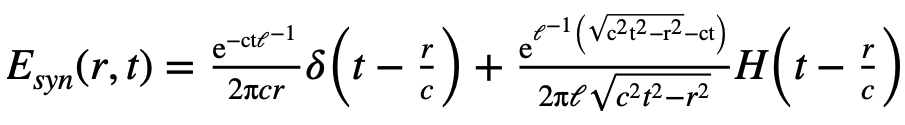

* l scattering mean free paths 
* c is the Rayleigh wave velocity
* r is the distance between the source and receiver
* H is the Heaviside function

The sum of squared residuals (SSR) between *Eobs and Esyn* was calculated, and the values of the parameters l and b that minimize SSR through the grid search were determined. <br>


An energy density with the spatially homogeneous intrinsic absorption is obtained by multiplying e^-bt with the right-hand-side of Equation (1), where ***b is intrinsic absorption parameter***


*Here i is the number of time windows and j is the number of station pairs.* from Hirose et al. (2022)  --> 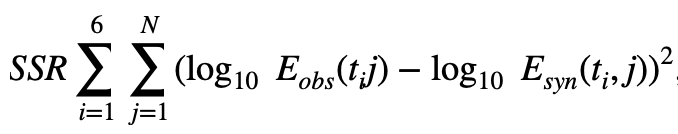

In [ ]:
def plot_fitting_curves(mean_free,intrinsic_b,tt,Eobs,Esyn,fname,dist,twin):
    numb=len(intrinsic_b)
    plt.figure(figsize=(8,2))
    for nb in range(numb):
    
        plt.yscale('log', base=10)
        #plt.xlim(0,120) 
        pymin=np.min(Eobs[nb][:-2]/2)
        pymax=np.max(Eobs[nb][:-2]*2)
        plt.ylim( pymin , pymax )
        plt.plot( tt, Eobs[nb], "k-", linewidth=0.5)
        plt.plot( tt, Esyn[nb], "b-", linewidth=1)
        plt.plot([twin[0],twin[0],twin[-1],twin[-1],twin[0]],[pymin, pymax,pymax,pymin,pymin],"r", linewidth=2)

    plt.title("%s  %.2fkm   @%4.2f-%4.2f Hz, mean_free: %.2f  b: %.2f~%.2f"
            % ( fname,dist,fmin,fmax,mean_free,y[0],y[-1]))
    plt.xlabel("Time [s]")
    plt.ylabel("Energy density Amplitude")
    plt.tight_layout()   
    plt.show()
                    

In [ ]:
cvel=[2.6, 2.0, 1.8]
x=np.zeros(1)    # mean_free_path search array
y=np.zeros(30)     # intrinsic_b search array

Esyn_temp=np.ndarray((len(x),len(y),npts//2+1))
Eobs_temp=np.ndarray((len(x),len(y),npts//2+1))

In [ ]:
SSR_final=np.ndarray((len(x),len(y)))
SSR_final[:][:]=0.

SSR=np.ndarray((nfreq,len(x),len(y)))
SSR[:][:][:]=0.

for fb in range(nfreq):
    fmin=freq[fb]
    fmax=freq[fb+1]
    c=cvel[fb]
    SSR_final[:][:]=0.
    for aa in range(fnum):
        #r=float(vdist[aa]) #+0.000001
        # for single station setting
        r=0.    
        twindow=[]
        twindow=range(int(twinbe[aa][fb][0]),int(twinbe[aa][fb][1]),1)
        SSR_temppp=np.ndarray((len(x),len(y),len(twindow)))

        # grid search in combination of mean_free_path and intrinsic_b
        Esyn_temp[:][:][:]=0.
        Eobs_temp[:][:][:]=0.
        
        for nfree in range(len(x)):
            mean_free= 0.4 + 0.2 *nfree
            x[nfree]=mean_free
            for nb in range(len(y)):
                intrinsic_b=0.01*(nb+1)
                y[nb]=intrinsic_b        

                # calculate the Esyn and SSR for combination of mean_free_path and intrinsic_b
                for twn in range(npts//2+1):
                    tm=dt*twn
                    Eobs_temp[nfree][nb][twn]= fmsv_mean[aa][fb+1][twn]
                    
                    s0=c**2 * tm**2 -r**2
                    if s0 <= 0:
                        #print(twn,tm,s0,tm-r/c)
                        continue
                        
                    tmp=ESYN_RadiaTrans_onesta(mean_free, tm , r, c)
                    Esyn_temp[nfree][nb][twn]= tmp * math.exp(-1* intrinsic_b * tm)  
                # using scalar factor for further fitting processes --> shape matters more than amplitude
                                                  
                #### specific window --> find the scaling factor in the specific window
                for tsn in range(len(twindow)):
                    tsb=int(twindow[tsn]//dt)
                    SSR_temppp[nfree][nb][tsn]=0.
                    SSR_temppp[nfree][nb][tsn]=(math.log10(Eobs_temp[nfree][nb][tsb]) - math.log10(Esyn_temp[nfree][nb][tsb]))
                   
                crap=np.mean(SSR_temppp[nfree][nb])
                Esyn_temp[nfree][nb]*=(10**crap)  # scale the Esyn
            
            #### specific window 
            #### Calculate the SSR in the specific window            
                for tsn in range(len(twindow)):
                    tsb=int(twindow[tsn]//dt)
                    tse=int((twindow[tsn]+1)//dt)
                    SSR_temp=0.
                    for twn in range(tsb,tse):
                        SSR_temp+=(math.log10(Eobs_temp[nfree][nb][twn]) - math.log10(Esyn_temp[nfree][nb][twn]))**2
                SSR_final[nfree][nb]+=SSR_temp
            # --- time comsuming for plotting out individual fitting curves  
            #plot_fitting_curves(mean_free,y,fmsv_mean[aa][0][:],Eobs_temp[nfree],Esyn_temp[nfree],fname[aa],vdist[aa],twindow)
        #print("mean_free: %.2f " % mean_free,", intrinsic_b %.2f " %  intrinsic_b,"SSR: %.4f" % SSR_temp)
        SSR_final= SSR_final / (np.min(SSR_final[:][:]))
    SSR[fb]=SSR_final


### Step 3 --- Determination of best-fit parameters 

In [ ]:
def plot_fitting_result(mean_free,intrinsic_b,tt,Eobs,Esyn,fname,dist,twin,fmin,fmax):
    plt.figure(figsize=(6,2))
    plt.yscale('log', base=10)

    pymax=np.max(Eobs[:-2]*5)
    pymin=10**(-6)
    plt.ylim( pymin , pymax )
    plt.plot( tt, Eobs, "k-", linewidth=1)
    plt.plot( tt, Esyn, "b--", linewidth=1)
    plt.plot([twin[0],twin[0],twin[-1],twin[-1],twin[0]],[pymin, pymax,pymax,pymin,pymin],"r", linewidth=2)

    plt.title("%s  %.2fkm   @%4.2f-%4.2f Hz, mean_free: %.2f  b: %.2f"
            % ( fname,dist,fmin,fmax,mean_free,intrinsic_b))
    plt.xlabel("Time [s]")
    plt.ylabel("Energy density Amp")
    plt.tight_layout()   
    plt.show()
                    

In [ ]:

result_intb=np.ndarray((nfreq))
result_mfp=np.ndarray((nfreq))
Eobs=np.ndarray((nfreq,npts//2+1))
Esyn=np.ndarray((nfreq,npts//2+1))
temppp=np.ndarray((len(twindow)))
aa=0
r=np.take(vdist[aa],0)+0.000001
for fb in range(nfreq): 
    fmin=freq[fb]
    fmax=freq[fb+1]

    loc=np.where(SSR[fb].T == np.amin(SSR[fb].T))
    locx=list(zip(loc[0], loc[1]))
    print("%4.2f-%4.2f Hz " % (fmin,fmax),"loc ",loc)
    ymin=y[loc[0]]
    xmin=x[loc[1]]
    print(" Station Pair :",sta_pair ,", intrinsic_b %.2f " % ymin,"mean_free: %.2f " % xmin)
    result_intb[fb]=np.take(ymin,0)
    result_mfp[fb]=np.take(xmin,0)
    for twn in range(npts//2+1):
        tm=dt*twn
        s0=c**2 * tm**2 -r**2
        if s0 <= 0:
            continue
        Eobs[fb][twn]=fmsv_mean[aa][fb+1][twn]
        tmp=ESYN_RadiaTrans_onesta(result_mfp[fb], tm ,r, c)
        Esyn[fb][twn]= tmp * math.exp(-1 * result_intb[fb] * tm )
        
    for tsn in range(len(twindow)):
        tsb=int(twindow[tsn]//dt)
        temppp[tsn]=0.
        temppp[tsn]=(math.log10(Eobs[fb][tsb]) - math.log10(Esyn[fb][tsb]))

        #print("tsn",tsn,tsb,tse,"Eobs %.2f" % Eobs_temp[nfree][nb][tsn],"Esyn %.2e" % Esyn_temp[nfree][nb][tsn],
        #    "SSR_temp %.2f" % SSR_temppp[nfree][nb][tsn],"crap",crap,res_max)  
    crap=np.mean(temppp)
    Esyn[fb]*=(10**crap)  
    plot_fitting_result(result_mfp[fb],result_intb[fb],fmsv_mean[aa][0][:],
                        Eobs[fb],Esyn[fb],sta_pair,vdist[aa],twinbe[aa][fb],fmin,fmax)


## Plotting SSR (for inter-station measurement)

In [ ]:
def plot_grid_searching(sta_pair,freq,SSR):
    nfreq=len(freq)-1
    
    fig, ax = plt.subplots(1,nfreq, figsize=(16,4), sharex=False)
    
    for fb in range(nfreq): 
        fmin=freq[fb]
        fmax=freq[fb+1]

        loc=np.where(SSR[fb].T == np.amin(SSR[fb].T))
        locx=list(zip(loc[0], loc[1]))
        print("%4.2f-%4.2f Hz " % (fmin,fmax),"loc ",loc)
        ymin=y[loc[0]]
        xmin=x[loc[1]]
        print(" intrinsic_b %.2f " % ymin,"mean_free: %.2f " % xmin)
        result_intb[fb]=ymin
        result_mfp[fb]=xmin

        grid = SSR[fb].T
        im=ax[fb].imshow(grid,extent=(x.min(), x.max(), y.max(), y.min()), aspect='auto',cmap = 'viridis_r',interpolation='spline16' )
        #im=ax[fb].imshow(grid,aspect='auto',cmap = 'viridis_r' )
        im.set_clim(1,1.3)    
        cb=plt.colorbar(im,extend='max')
        cb.set_label('SSR/SSR_min', rotation=90, labelpad=14)
        ax[fb].set_title("%s  SSR  @%4.2f-%4.2f Hz" % (sta_pair,fmin,fmax) )
        ax[fb].set_xlabel("mean free path")
        ax[fb].set_ylabel("intrinsic_b")
        ax[fb].invert_yaxis()
        ax[fb].plot(xmin,ymin,"+", markersize=20, color='red')

    plt.tight_layout() 
    plt.show()     
    


In [ ]:
#plot_grid_searching(sta_pair,freq,SSR)
